Plots 4 through 7, create a netcdf file for paraview to plot 3d init pic

In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
from scipy import interpolate

import pandas as pd
plt.rcParams.update({'font.size': 22})
pd.set_option('display.float_format', lambda x: '%.2e' % x)
FELTOR_PATH="../feltor" # path to the feltor library

In [2]:
# Here we use the Navier-Stokes program and feltordiag with zero timesteps to compute the toroidal averages
def create_inputfile() :
    inputfile = fp.load_calibration_default()
    inputfile["magnetic_field"]["params"] = mag.select("guenter.json")

    scaleR = [1.0,1.0]
    scaleZ = [1.0,1.0]
    inputfile["grid"] = {"Nx" : 32, "Ny" : 32, "Nz": 20, "n": 3,
                         "scaleR" : scaleR, "scaleZ" : scaleZ}
    inputfile["boundary"]["wall"] = {"type" : "none" }
    inputfile["boundary"]["sheath"] = {"type" : "none" }

    inputfile["init"] ={
        "type" : "fields",
        "density": {    
            "type" : "ne",
            "ntilde": {
                "type" : "blob", # secret init condition in Feltor
                "amplitude" : 4.0,
                "posX" : 0.5,
                "posY" : 0.0,
                "sigma" : 0.05,
                "rk4eps" :1e-6,
                "revolutions" : 1,
                "parallel" : "exact-gaussian",
                "sigma_z" : 0.4
            },
            "profile" : {
                "type" : "const",
                "background" : 0.2
            },
            "damping": {
                "type" : "none"
            }
        },
        "potential" : {"type" : "zero_pol"},
        "velocity"  : {"type" : "zero"}, 
        "aparallel" : {"type" : "zero"}
    }
    inputfile["regularization"] = {
        "direction" : "forward",
        "nu_perp_n" : 0,
        "nu_perp_u" : 0,
        "nu_parallel_n" : 0,
        "order" : 2
    }
    inputfile["source"] = {
        "minne" : 0.,
        "type" : "zero"
    }
    inputfile["timestepper"] = {
        "type" : "adaptive",
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-7,
        "atol" : 1e-10,
        "output-mode" : "Tend",
        "reject-limit"  : 2,
        "Tend" : 1e-4 # choose small we do not simulate anything
    }
    inputfile["FCI"]["periodify"] = False
    inputfile["FCI"]["refine"] = [5,5]
    inputfile["FCI"]["interpolation-method"] = "linear"
    inputfile["advection"]= {
        "type"  : "velocity-staggered",
        "slope-limiter" : "none"}
    inputfile["physical"]["tau"] = 1.0
    inputfile["physical"]["viscosity"] = "value"
    inputfile["physical"]["nu_parallel"] = [0,0.1]
    inputfile["flags"] = []
    inputfile["output"] = {
        "type" : "netcdf",
        "inner_loop" : 1,
        "itstp" : 1,
        "maxout" : 0,
        "compression" : [1,1]
    }
    return inputfile


In [3]:
print(mag.select("guenter.json"))

{'equilibrium': 'guenter', 'description': 'square', 'I_0': 10.0, 'R_0': 3.0, 'comment': 'Sine functions; Guenter et al, J. Comput. Phys. 209 (2005) 354'}


In [4]:
def create_default_config():
    configfile = {
        # for feltordiag
        "n": 3,
        "Npsi": 64,
        "Neta": 640,
        "Kphi": 10,
        "fsa" : "convoluted-toroidal-average",
        # for interpolate in 3d
        "fine-grid-factor" : 2,
        "time-reduction-factor" : 1
    }
    return configfile

config = create_default_config()
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [5]:
def plot( simfile, name, filename):
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    fci = pp["FCI"]
    
    print( f"{simfile}")
    print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
    print( f", method: {fci['interpolation-method']}")
    frows = 1
    fcols = 1
    x = ncin["x"][:]
    y = ncin["y"][:]
    xc = np.kron( np.ones(np.shape(y)),x).reshape( (np.size(y), np.size(x)))
    yc = np.kron( y, np.ones(np.shape(x))).reshape( (np.size(y), np.size(x)))
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*12,frows*9),dpi= 80, facecolor='w', edgecolor='k')

    im = ax.pcolormesh(xc, yc, ncin[name][0,:,:],
                          vmin = 0.2, vmax = 0.4,
                       cmap="gist_heat_r", shading="gouraud") 
    fig.colorbar(im, ax=ax)
    ax.axis("scaled")
    ax.set_xlabel( "R [m]")
    ax.set_ylabel( "Z [m]")
    plt.savefig( filename,  bbox_inches = 'tight')
    plt.show()
    


In [6]:
simulator = simplesim.Manager( executable="./feltor.sh", directory="Averages/data", filetype="nc")
diagnoser = simplesim.Manager( executable="./feltordiag.sh", directory="Averages/diag", filetype="nc")
interpolator = simplesim.Manager( executable ="./feltorplot.sh",
                                  directory="Averages/plot", filetype = "nc")


Existing simulation 38ae27...d45b4f.nc
Existing simulation 38ae27...d45b4f.nc
Averages/data/38ae277c2c66b04095d32132fce905f280d45b4f.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


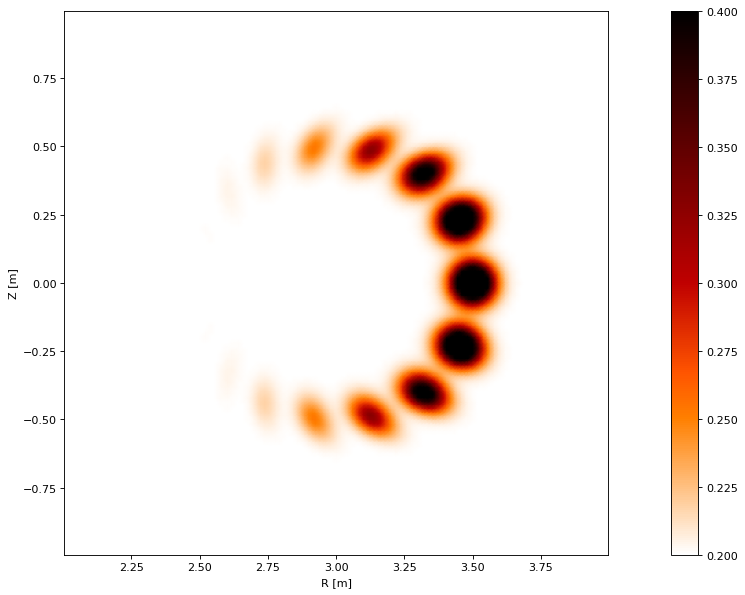

Averages/diag/38ae277c2c66b04095d32132fce905f280d45b4f.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


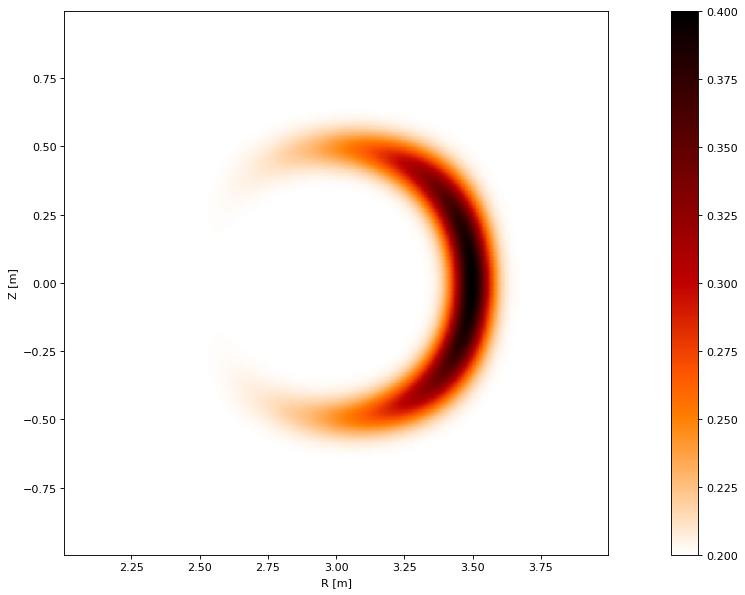

In [7]:
# this is to generate a plot for the average paper
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 10

config = create_default_config()
config["Kphi"] = 10
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    
simfile =  simulator.create( simulationfile, error = "display")
diagfile = diagnoser.create( simulationfile)
#plotfile = interpolator.create( simulationfile)
plot(simfile,  "ions_ta2d", "init-cylinder-ta.png")
plot(diagfile, "ions_cta2d", "init-cylinder-cta10.png")

Existing simulation a907e5...3dbb06.nc
Existing simulation a907e5...3dbb06.nc
Averages/data/a907e5d53be2fd10d5031f046a90c0565a3dbb06.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


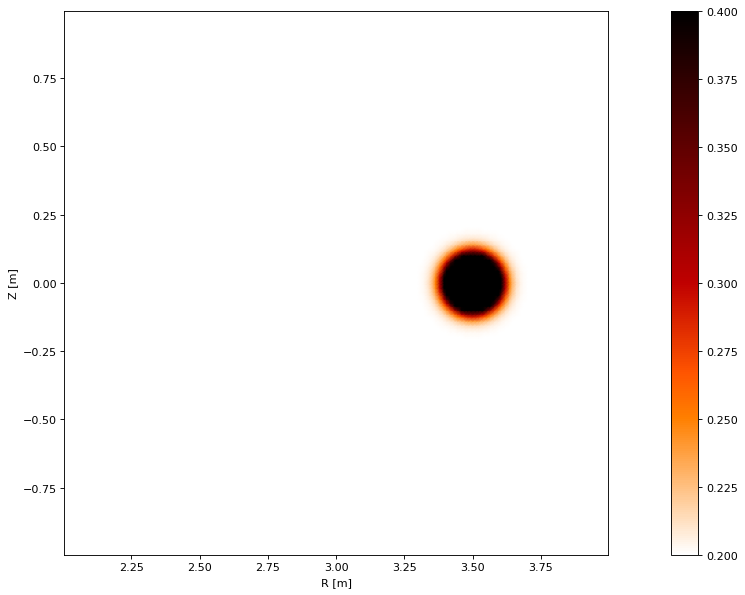

Averages/diag/a907e5d53be2fd10d5031f046a90c0565a3dbb06.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


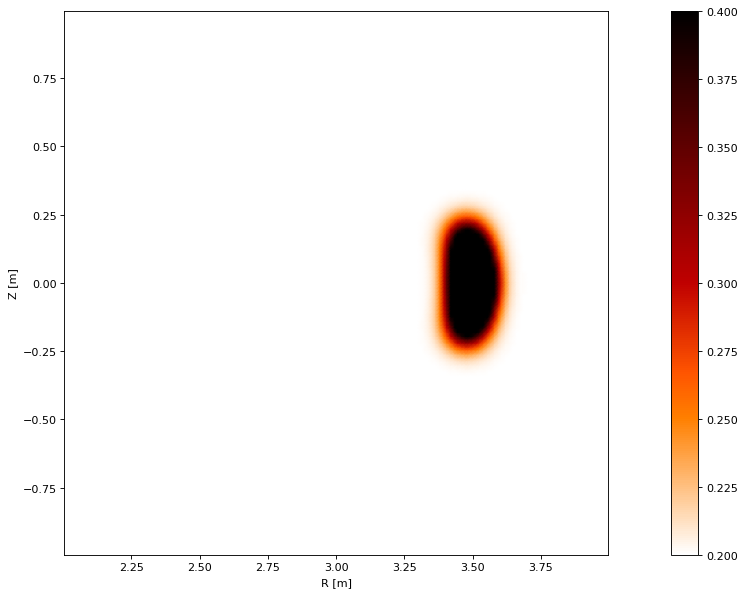

In [8]:
# this is to generate a plot for the average paper
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 10
simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal-gaussian"


simfile =  simulator.create( simulationfile)
diagfile = diagnoser.create( simulationfile)
#plotfile = interpolator.create( simulationfile)
plot(simfile, "ions_ta2d", "init-toroidal-ta.png")
plot(diagfile, "ions_cta2d", "init-toroidal-cta10.png")

Existing simulation 38ae27...d45b4f.nc
Existing simulation 38ae27...d45b4f.nc
Averages/diag/38ae277c2c66b04095d32132fce905f280d45b4f.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


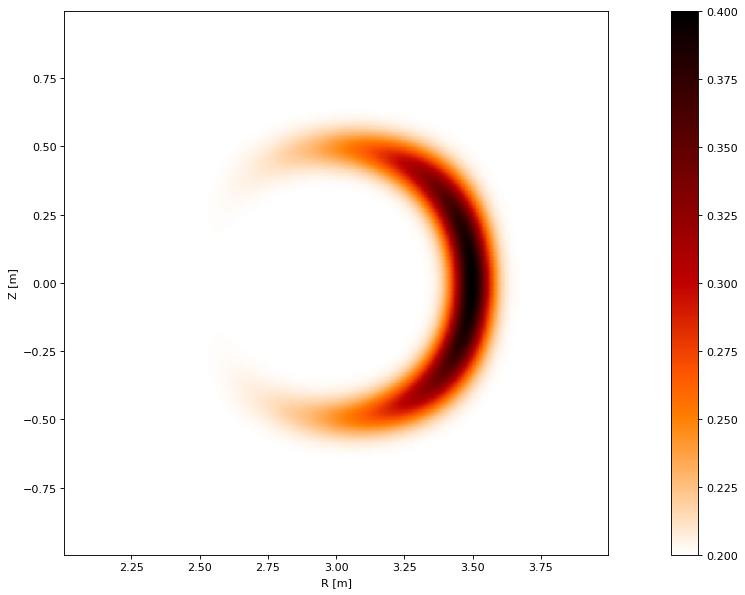

Existing simulation 38ae27...d45b4f.nc
Averages/diag/38ae277c2c66b04095d32132fce905f280d45b4f.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


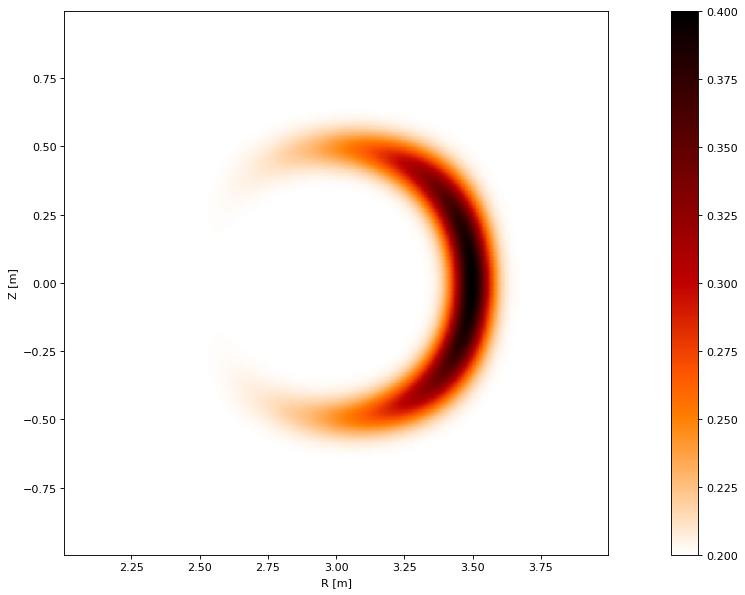

Existing simulation 38ae27...d45b4f.nc
Averages/diag/38ae277c2c66b04095d32132fce905f280d45b4f.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


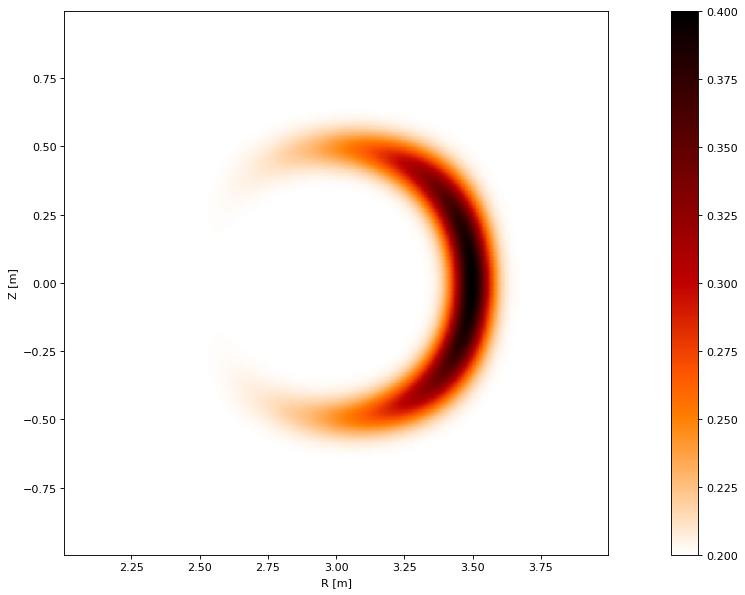

Existing simulation 38ae27...d45b4f.nc
Averages/diag/38ae277c2c66b04095d32132fce905f280d45b4f.nc
n: 3, Nx: 50, Nz: 10, mx: 5, method: linear


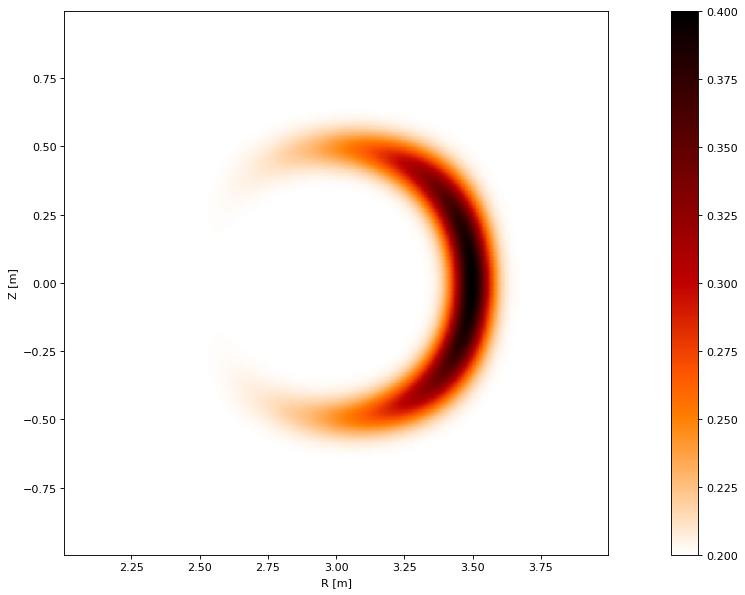

In [9]:
# this is to generate a plot for the average paper
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 10

simfile =  simulator.create( simulationfile)

config = create_default_config()
for Kphi in [1,2,5,10]:
    config["Kphi"] = Kphi
    with open( "config.json", 'w') as f:
        json.dump( config, f,
            sort_keys=True, ensure_ascii=True, indent=4)
    diagfile = diagnoser.create( simulationfile)

    plot(diagfile, "ions_cta2d", "init-cylinder-cta"+str(Kphi)+".png")

In [10]:
# let us generate a plot file to plot a nice 3d picture in paraview
simulationfile = create_inputfile()

simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 200

config = create_default_config()
config["Kphi"] = 10
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    
simfile =  simulator.create( simulationfile, error="display")
diagfile = diagnoser.create( simulationfile)
plotfile = interpolator.create( simulationfile)
print(plotfile)
# load plot_init_cylinder_3d statefile in paraview

Existing simulation 89f2d0...1b42c9.nc
Existing simulation 89f2d0...1b42c9.nc
Existing simulation 89f2d0...1b42c9.nc
Averages/plot/89f2d0c695868a8e6d7157c536c670af3b1b42c9.nc


In [11]:
print( "FILE CONTENTS")
ncin = Dataset( diagfile, 'r', format="NETCDF4")
for v in ncin.variables:
#     if v == "time" : 
#         print(f"{v} {ncin.variables[v].shape}")
#     else : 
    print( f"{v} {ncin.variables[v].shape}")
#     ,
#             f"\t{ ncin.variables[v].long_name}")
ncin.close()

FILE CONTENTS
psi (192,)
dvdpsi (192,)
psi_vol (192,)
psi_area (192,)
rho (192,)
rho_p (192,)
q-profile (192,)
psi_psi (192,)
psit1d (192,)
rho_t (192,)
time (1,)
y (150,)
x (150,)
eta (1920,)
electrons_cta2d (1, 150, 150)
electrons_cta2dX (1, 1920, 192)
electrons_fluc2d (1, 150, 150)
electrons_fsa (1, 192)
electrons_fsa2d (1, 150, 150)
electrons_ifs (1, 192)
electrons_ifs_lcfs (1,)
electrons_ifs_norm (1,)
electrons_std_fsa (1, 192)
ions_cta2d (1, 150, 150)
ions_cta2dX (1, 1920, 192)
ions_fluc2d (1, 150, 150)
ions_fsa (1, 192)
ions_fsa2d (1, 150, 150)
ions_ifs (1, 192)
ions_ifs_lcfs (1,)
ions_ifs_norm (1,)
ions_std_fsa (1, 192)
Ue_cta2d (1, 150, 150)
Ue_cta2dX (1, 1920, 192)
Ue_fluc2d (1, 150, 150)
Ue_fsa (1, 192)
Ue_fsa2d (1, 150, 150)
Ue_ifs (1, 192)
Ue_ifs_lcfs (1,)
Ue_ifs_norm (1,)
Ue_std_fsa (1, 192)
Ui_cta2d (1, 150, 150)
Ui_cta2dX (1, 1920, 192)
Ui_fluc2d (1, 150, 150)
Ui_fsa (1, 192)
Ui_fsa2d (1, 150, 150)
Ui_ifs (1, 192)
Ui_ifs_lcfs (1,)
Ui_ifs_norm (1,)
Ui_std_fsa (1, 192)
po

niui2_ifs (1, 192)
niui2_ifs_lcfs (1,)
niui2_ifs_norm (1,)
niui2_std_fsa (1, 192)
resistivity_tt_cta2d (1, 150, 150)
resistivity_tt_cta2dX (1, 1920, 192)
resistivity_tt_fluc2d (1, 150, 150)
resistivity_tt_fsa (1, 192)
resistivity_tt_fsa2d (1, 150, 150)
resistivity_tt_ifs (1, 192)
resistivity_tt_ifs_lcfs (1,)
resistivity_tt_ifs_norm (1,)
resistivity_tt_std_fsa (1, 192)
see_tt_cta2d (1, 150, 150)
see_tt_cta2dX (1, 1920, 192)
see_tt_fluc2d (1, 150, 150)
see_tt_fsa (1, 192)
see_tt_fsa2d (1, 150, 150)
see_tt_ifs (1, 192)
see_tt_ifs_lcfs (1,)
see_tt_ifs_norm (1,)
see_tt_std_fsa (1, 192)
sei_tt_cta2d (1, 150, 150)
sei_tt_cta2dX (1, 1920, 192)
sei_tt_fluc2d (1, 150, 150)
sei_tt_fsa (1, 192)
sei_tt_fsa2d (1, 150, 150)
sei_tt_ifs (1, 192)
sei_tt_ifs_lcfs (1,)
sei_tt_ifs_norm (1,)
sei_tt_std_fsa (1, 192)
jvee_tt_cta2d (1, 150, 150)
jsee_tt_cta2dX (1, 1920, 192)
jvee_tt_fluc2d (1, 150, 150)
jvee_tt_fsa (1, 192)
jvee_tt_fsa2d (1, 150, 150)
jvee_tt_ifs (1, 192)
jvee_tt_ifs_lcfs (1,)
jvee_tt_ifs_norm

jvparbphidiai_tt_ifs_norm (1,)
jvparbphidiai_tt_std_fsa (1, 192)
jvparbphikappai_tt_cta2d (1, 150, 150)
jsparbphikappai_tt_cta2dX (1, 1920, 192)
jvparbphikappai_tt_fluc2d (1, 150, 150)
jvparbphikappai_tt_fsa (1, 192)
jvparbphikappai_tt_fsa2d (1, 150, 150)
jvparbphikappai_tt_ifs (1, 192)
jvparbphikappai_tt_ifs_lcfs (1,)
jvparbphikappai_tt_ifs_norm (1,)
jvparbphikappai_tt_std_fsa (1, 192)
jvparApar_tt_cta2d (1, 150, 150)
jsparApar_tt_cta2dX (1, 1920, 192)
jvparApar_tt_fluc2d (1, 150, 150)
jvparApar_tt_fsa (1, 192)
jvparApar_tt_fsa2d (1, 150, 150)
jvparApar_tt_ifs (1, 192)
jvparApar_tt_ifs_lcfs (1,)
jvparApar_tt_ifs_norm (1,)
jvparApar_tt_std_fsa (1, 192)
jvparbphiApar_tt_cta2d (1, 150, 150)
jsparbphiApar_tt_cta2dX (1, 1920, 192)
jvparbphiApar_tt_fluc2d (1, 150, 150)
jvparbphiApar_tt_fsa (1, 192)
jvparbphiApar_tt_fsa2d (1, 150, 150)
jvparbphiApar_tt_ifs (1, 192)
jvparbphiApar_tt_ifs_lcfs (1,)
jvparbphiApar_tt_ifs_norm (1,)
jvparbphiApar_tt_std_fsa (1, 192)
divjpare_tt_cta2d (1, 150, 150)


In [12]:
# Construct the Gaussian weights on our grids
def gauss_weights( js) :
    n = js["n"]
    Nx = js["Nx"]
    Ny = js["Ny"]
    lx = 2
    ly = 2
    hx = lx/Nx
    hy = ly/Ny
    (x,w) = np.polynomial.legendre.leggauss(js["n"])
    weights1dX = np.tile( w, js["Nx"])
    weights1dY = np.tile( w, js["Ny"])
    return np.reshape( np.kron( weights1dY, weights1dX)*hy/2.0*hx/2.0 , (js["n"]*js["Ny"], js["n"]*js["Nx"]))

In [13]:
def compare_ta( simfile, bigfile, name1, name2) :
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    bigg = Dataset( bigfile, 'r', format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    fci = pp["FCI"]
    weights = gauss_weights( gg)

    num = ncin[name1][0,:,:]-0.2
    sol = bigg[name2][0,:,:]-0.2
    diff = num - sol
    norm_diff = np.sqrt(np.sum( diff[:,:]**2*weights ))
#     norm_diff = np.max(np.abs(diff))
    norm_sol = np.sqrt(np.sum( sol[:,:]**2*weights ))
#     norm_sol = np.max(np.abs(sol))
    return norm_diff/ norm_sol

In [14]:
#define conversion function 
def orderToString(x): 
    if np.isnan(x) : return 'n/a'
    return'%.2f'% x

def errorToString(x):
    return '%.2e' % x

In [15]:
# Create one big file
lines = list()
for Nphi in [5, 10, 20, 40,80] :
    simulationfile = create_inputfile()

    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "exact-gaussian"
    simfile =  simulator.create( simulationfile)
    diagfile = diagnoser.create( simulationfile)
    simulationfile["grid"]["Nz"] = 400
    bigfile = simulator.create( simulationfile)
    bigdiag = diagnoser.create( simulationfile)
    lines.append( [Nphi, compare_ta( simfile, bigfile, "ions_ta2d", "ions_ta2d"),
                  compare_ta( diagfile, bigfile, "ions_cta2d", "ions_ta2d")])
#     lines.append( [Nphi, compare_ta( simfile, bigdiag, "ions_ta2d", "ions_cta2d"),
#                   compare_ta( diagfile, bigdiag, "ions_cta2d", "ions_cta2d")])

df = pd.DataFrame(lines, columns=["$N_\\varphi$", "error.PAT", "error.PAL"])
for name in ["PAT", "PAL"]:
    df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
    df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
        np.log( df["$N_\\varphi$"].shift(1)/df["$N_\\varphi$"]))
df.set_index(['$N_\\varphi$'], inplace=True) 
headers = [ "$\langle f \rangle^T_{\\varphi}$ Eq.~\eqref{eq:pat}",
            "$\langle f \rangle^{ST}_{\\varphi}$ Eq.~\eqref{eq:pal}"
           ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_fieldaligned_pat.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

Existing simulation 9a4064...49dc30.nc
Existing simulation 9a4064...49dc30.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 38ae27...d45b4f.nc
Existing simulation 38ae27...d45b4f.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 4056e7...7544b9.nc
Existing simulation 4056e7...7544b9.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation c10ac9...c83487.nc
Existing simulation c10ac9...c83487.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 63fd84...7062d3.nc
Existing simulation 63fd84...7062d3.nc
Existing simulation 636e8f...0eb4c0.nc
Existing simulation 636e8f...0eb4c0.nc


<ipython-input-15-dacdb1e9d7c4>:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(bytes(string_df.to_latex(


$\langle f \rangle^T_{\varphi}$ Eq.~\eqref{eq:pat}         \
                                                         error  order   
$N_\varphi$                                                             
5                                                     1.32e+00    n/a   
10                                                    6.20e-01   1.09   
20                                                    5.60e-02   3.47   
40                                                    1.06e-05  12.37   
80                                                    1.52e-07   6.12   

            $\langle f \rangle^{ST}_{\varphi}$ Eq.~\eqref{eq:pal}        
                                                            error order  
$N_\varphi$                                                              
5                                                     7.06e-02      n/a  
10                                                    1.76e-02     2.01  
20                                                    4.40e-03     2.00  
40                                                    1.30e-03     1.76  
80                                                    6.88e-04     0.92

In [16]:
lines = list()
for Nphi in [5, 10, 20, 40,80] :
    simulationfile = create_inputfile()
    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal-gaussian"
    simfile =  simulator.create( simulationfile)
    diagfile = diagnoser.create( simulationfile)
    simulationfile["grid"]["Nz"] = 400
    bigfile = simulator.create( simulationfile)
    bigdiag = diagnoser.create( simulationfile)
    lines.append( [Nphi, compare_ta( simfile, bigfile, "ions_ta2d", "ions_ta2d"),
                  compare_ta( diagfile, bigfile, "ions_cta2d", "ions_ta2d")])
    #plot_ta(simfile)
df = pd.DataFrame(lines, columns=["$N_\\varphi$", "error.PAT", "error.PAL"])
for name in ["PAT", "PAL"]:
    df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
    df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
        np.log( df["$N_\\varphi$"].shift(1)/df["$N_\\varphi$"]))
df.set_index(['$N_\\varphi$'], inplace=True) 
headers = [ "$\langle f \rangle^T_{\\varphi}$ Eq.~\eqref{eq:pat}",
            "$\langle f \rangle^{ST}_{\\varphi}$ Eq.~\eqref{eq:pal}"
           ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_toroidal_pat.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

Existing simulation 52d596...11a69e.nc
Existing simulation 52d596...11a69e.nc
Existing simulation 849473...bfaee6.nc
Existing simulation 849473...bfaee6.nc
Existing simulation a907e5...3dbb06.nc
Existing simulation a907e5...3dbb06.nc
Existing simulation 849473...bfaee6.nc
Existing simulation 849473...bfaee6.nc
Existing simulation 481dd5...68cc31.nc
Existing simulation 481dd5...68cc31.nc
Existing simulation 849473...bfaee6.nc
Existing simulation 849473...bfaee6.nc
Existing simulation ea5847...0dab92.nc
Existing simulation ea5847...0dab92.nc
Existing simulation 849473...bfaee6.nc
Existing simulation 849473...bfaee6.nc
Existing simulation aa852d...ec2b6d.nc
Existing simulation aa852d...ec2b6d.nc
Existing simulation 849473...bfaee6.nc
Existing simulation 849473...bfaee6.nc


<ipython-input-16-d043d7f79067>:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(bytes(string_df.to_latex(


$\langle f \rangle^T_{\varphi}$ Eq.~\eqref{eq:pat}        \
                                                         error order   
$N_\varphi$                                                            
5                                                     3.33e-03   n/a   
10                                                    9.02e-04  1.88   
20                                                    2.29e-04  1.98   
40                                                    5.71e-05  2.00   
80                                                    1.39e-05  2.04   

            $\langle f \rangle^{ST}_{\varphi}$ Eq.~\eqref{eq:pal}        
                                                            error order  
$N_\varphi$                                                              
5                                                     7.66e-01      n/a  
10                                                    5.62e-01     0.45  
20                                                    2.83e-01     0.99  
40                                                    9.49e-02     1.58  
80                                                    2.59e-02     1.87

In [17]:
# Construct the Gaussian weights on our grids
def gauss_weights1d( js) :
    n = js["n"]
    Nx = js["Npsi"]
    lx = 1 # length drops out in relative error BUT NOT ABSOLUTE
    hx = lx/Nx
    (x,w) = np.polynomial.legendre.leggauss(js["n"])
    weights1dX = np.tile( w, js["Npsi"])*hx/2
    return weights1dX

In [18]:
def compare_fsa( simulationfile) :
    config = create_default_config()
    weights = gauss_weights1d( config)[:]
    config["fsa"] = "toroidal-average"
    with open( "config.json", 'w') as f:
        json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    diagfile1 = diagnoser.recreate( simulationfile)
    ncin1 = Dataset( diagfile1, 'r', format="NETCDF4")
    num = ncin1["ions_fsa"][:]
    norm = np.sqrt(np.sum( num[:]**2*weights ))
    print(norm)
    ncin1.close()

    config["fsa"] = "convoluted-toroidal-average"
    with open( "config.json", 'w') as f:
        json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    diagfile2 = diagnoser.recreate( simulationfile)
    ncin2 = Dataset( diagfile2, 'r', format="NETCDF4")  
    sol = ncin2["ions_fsa"][:]
    norm = np.sqrt(np.sum( sol[:]**2*weights ))
    print(norm)
    ncin2.close()
    

    diff = num - sol
    #norm_diff = np.max(np.abs(diff))
    norm_diff = np.sqrt(np.sum( diff[:]**2*weights ))
    #norm_sol = np.max(np.abs(sol))
    norm_sol = np.sqrt(np.sum( num[:]**2*weights ))

    return norm_diff/ norm_sol

In [19]:
# Here, we create a comparison between the fsa and fsa(smooth)
linesT = list()
for Nphi in [5,10,20,40] :
    simulationfile = create_inputfile()
    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal-gaussian"
    simfile =  simulator.create( simulationfile)
    print(simfile)
    linesT.append( [Nphi, compare_fsa( simulationfile)])
    #plot_ta(simfile)

Existing simulation 52d596...11a69e.nc
Averages/data/52d5962287daffc17436fc6f1990627d2611a69e.nc
Running simulation 52d596...11a69e.nc
0.21184592514929268
Running simulation 52d596...11a69e.nc
0.2116243403610298
Existing simulation a907e5...3dbb06.nc
Averages/data/a907e5d53be2fd10d5031f046a90c0565a3dbb06.nc
Running simulation a907e5...3dbb06.nc
0.21181437996039862
Running simulation a907e5...3dbb06.nc
0.21175770441835565
Existing simulation 481dd5...68cc31.nc
Averages/data/481dd58db0cc443ed96e4e5ab518dfe3a368cc31.nc
Running simulation 481dd5...68cc31.nc
0.21180563235967254
Running simulation 481dd5...68cc31.nc
0.21179133596768807
Existing simulation ea5847...0dab92.nc
Averages/data/ea584757ab32ff80f3a140dd807d7056750dab92.nc
Running simulation ea5847...0dab92.nc
0.21180339442960938
Running simulation ea5847...0dab92.nc
0.2117997209842701


In [20]:
df = pd.DataFrame(linesT, columns=["$N_\\varphi$", "error.fsa"])
name = "fsa"
df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
np.log( df["$N_\\varphi$"].shift(1)/df["$N_\\varphi$"]))
df.set_index(['$N_\\varphi$'], inplace=True) 
headers = [ "$\langle f - S(f) \rangle/\langle f\rangle$ "  ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_fsa_smooth_toroidal.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

<ipython-input-20-a1a84dab6f84>:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(bytes(string_df.to_latex(


$\langle f - S(f) \rangle/\langle f\rangle$       
                                                   error order
$N_\varphi$                                                   
5                                               2.06e-03   n/a
10                                              5.36e-04  1.94
20                                              1.51e-04  1.83
40                                              3.83e-05  1.97

In [21]:
# Here, we create a comparison between the fsa and fsa(smooth)
linesE = list()
for Nphi in [5,10,20,40] :
    simulationfile = create_inputfile()
    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = Nphi
    simulationfile["init"]["density"]["ntilde"]["parallel"] = "exact-gaussian"
    simfile =  simulator.create( simulationfile)
    print(simfile)
    linesE.append( [Nphi, compare_fsa( simulationfile)])
    #plot_ta(simfile)

Existing simulation 9a4064...49dc30.nc
Averages/data/9a4064877d8815aad27d538dfb661dea9e49dc30.nc
Running simulation 9a4064...49dc30.nc
0.21086281996217066
Running simulation 9a4064...49dc30.nc
0.21072621001552563
Existing simulation 38ae27...d45b4f.nc
Averages/data/38ae277c2c66b04095d32132fce905f280d45b4f.nc
Running simulation 38ae27...d45b4f.nc
0.21086283737875308
Running simulation 38ae27...d45b4f.nc
0.21082779808708532
Existing simulation 4056e7...7544b9.nc
Averages/data/4056e7202ccc490a80d9ff973fee917c5d7544b9.nc
Running simulation 4056e7...7544b9.nc
0.21086286559592213
Running simulation 4056e7...7544b9.nc
0.21085394569409915
Existing simulation c10ac9...c83487.nc
Averages/data/c10ac978d03856c657921de4faa1734805c83487.nc
Running simulation c10ac9...c83487.nc
0.21086280196318452
Running simulation c10ac9...c83487.nc
0.2108605995464016


In [22]:
df = pd.DataFrame(linesE, columns=["$N_\\varphi$", "error.fsa"])
name = "fsa"
df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])
df["order."+name] = (np.log ( df["order."+name]/ df["order."+name].shift(1))/
    np.log( df["$N_\\varphi$"].shift(1)/df["$N_\\varphi$"]))
df.set_index(['$N_\\varphi$'], inplace=True) 
headers = [ "$\langle f - S(f)\rangle$ "  ]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_fsa_smooth_aligned.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

<ipython-input-22-43b621a1d252>:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(bytes(string_df.to_latex(


$\langle f - S(f)\rangle$       
                                 error order
$N_\varphi$                                 
5                             1.29e-03   n/a
10                            3.31e-04  1.96
20                            8.79e-05  1.91
40                            2.35e-05  1.90

In [23]:
# Here, we create a comparison between the volume integration
lines = list()
#for Nphi in [5]:#,10,20,40,80] :
simulationfile = create_inputfile()
simulationfile["grid"]["Nx"] =50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 5
simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal"
simfile =  simulator.create( simulationfile)
npsi = 3
for Npsi in [8,16,32,64,128] : 
    Neta = 10*Npsi
    config = create_default_config()
    config["fsa"] = "toroidal-average" # important because cta is not good for toroidal gaussian

    config["n"] = npsi
    config["Npsi"] = Npsi
    config["Neta"] = Neta
    with open( "config.json", 'w') as f:
        json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    diagfile = diagnoser.recreate( simulationfile)

    ncin = Dataset( diagfile, 'r', format="NETCDF4")
    num = ncin["ions_ifs_lcfs"][0]
    vol = 2*np.pi*ncin["vol"][:,npsi*int(Npsi/8):npsi*Npsi]*ncin["xc"][:,npsi*int(Npsi/8):npsi*Npsi]
    volumeX = np.sum( vol)
    print( "Npsi",Npsi,"Volume error in X-grid",  (volumeX-24*np.pi)/(24*np.pi))
    ncin.close()
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    num_ana = np.sum(ncin["ions"][0,:,:,:]*ncin["vol3d"][:,:,:])
    #print( (np.pi*(3+1)**2 - np.pi*(3-1)**2)*2)
    ana = 0.2*24*np.pi+0.6841011042693754
    print( num, num_ana, (num - num_ana )/ num_ana)


    lines.append( [Npsi, np.abs(num - num_ana)/num_ana])
    #plot_ta(simfile)


Existing simulation 34d3dd...b1040b.nc
Running simulation 34d3dd...b1040b.nc
Npsi 8 Volume error in X-grid -0.0028424764688546418
16.461626239259317 16.461389353383513 1.4390393831202302e-05
Running simulation 34d3dd...b1040b.nc
Npsi 16 Volume error in X-grid -0.0014203654919815976
16.463877218182375 16.461389353383513 0.00015113334272424844
Running simulation 34d3dd...b1040b.nc
Npsi 32 Volume error in X-grid -0.0007100737780377339
16.461897394760143 16.461389353383513 3.086260617033829e-05
Running simulation 34d3dd...b1040b.nc
Npsi 64 Volume error in X-grid -0.0003550232776046941
16.461690896836117 16.461389353383513 1.8318226130904078e-05
Running simulation 34d3dd...b1040b.nc
Npsi 128 Volume error in X-grid -0.00017750993767772814
16.461521445833014 16.461389353383513 8.024380364591521e-06


In [24]:
df = pd.DataFrame(lines[1:], columns=["$N_\\psi$", "error.ifs"])
for name  in ["ifs"] :
    df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])

    df["order."+name] = (np.log( df["order."+name]/ df["order."+name].shift(1))/
     np.log( df["$N_\\psi$"].shift(1)/df["$N_\\psi$"]))
df.set_index(['$N_\\psi$'], inplace=True) 
headers = [ "$|\int  f dV - \int  \langle f\rangle|dV/\int  \langle f\rangle$ dV"]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_ifs.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

<ipython-input-24-7e9531930551>:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(bytes(string_df.to_latex(


$|\int  f dV - \int  \langle f\rangle|dV/\int  \langle f\rangle$ dV  \
                                                                       error   
$N_\psi$                                                                       
16                                                 1.51e-04                    
32                                                 3.09e-05                    
64                                                 1.83e-05                    
128                                                8.02e-06                    

                
         order  
$N_\psi$        
16         n/a  
32        2.29  
64        0.75  
128       1.19

In [25]:
# Here, we create a comparison of area and arc length computation
lines2 = list()
#for Nphi in [5]:#,10,20,40,80] :
simulationfile = create_inputfile()
simulationfile["magnetic_field"]["params"] = mag.select("circular.json")
simulationfile["magnetic_field"]["params"]["a"] = 1.5
simulationfile["magnetic_field"]["params"]["b"] = 0.75
# simulationfile["magnetic_field"]["params"]["a"] = 1.0
# simulationfile["magnetic_field"]["params"]["b"] = 1.0
simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 5
simulationfile["init"]["density"]["ntilde"]["parallel"] = "toroidal"
simfile =  simulator.create( simulationfile)
npsi = 3
for Npsi in [2,4,8,16,32] : 
    Neta = 10*Npsi
    config = create_default_config()
    config["fsa"] = "toroidal-average" # important because cta is not good for toroidal gaussian

    config["n"] = npsi
    config["Npsi"] = Npsi
    config["Neta"] = Neta
    with open( "config.json", 'w') as f:
        json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)
    diagfile = diagnoser.recreate( simulationfile)

    ncin = Dataset( diagfile, 'r', format="NETCDF4")
    arclength = ncin["psi_arc"][:]
    area = ncin["psi_vol2d"][:]
    psi_psi = ncin["psi_psi"][:]
    areainterp = interpolate.interp1d( psi_psi, area, "cubic")
    arcinterp = interpolate.interp1d( psi_psi, arclength, "cubic")
#     print( areainterp(1))
    area0d = areainterp( 0)# - areainterp(0.75)
    arclength0d = arcinterp( 0)
    area0d_ana = 9/8*np.pi
#     area0d_ana = np.pi - np.pi*0.5**2
    arclength0d_ana = 7.26633616541076
#     arclength0d_ana = 2.0*np.pi
    print("Npsi", Npsi, "Arclength error ", (arclength0d-arclength0d_ana)/arclength0d_ana)
    print("Npsi", Npsi,  "Area error ", (area0d-area0d_ana)/area0d_ana)

    ncin.close()
    lines2.append( [Npsi, np.abs(arclength0d-arclength0d_ana)/arclength0d_ana, np.abs(area0d-area0d_ana)/area0d_ana])
    #plot_ta(simfile)


Existing simulation 9bbf2f...423ee8.nc
Running simulation 9bbf2f...423ee8.nc
Npsi 2 Arclength error  -0.0002776634102968714
Npsi 2 Area error  -1.0076801113009405e-06
Running simulation 9bbf2f...423ee8.nc
Npsi 4 Arclength error  -2.560412138989638e-07
Npsi 4 Area error  6.321006215429814e-08
Running simulation 9bbf2f...423ee8.nc
Npsi 8 Arclength error  -1.3775106422285584e-08
Npsi 8 Area error  1.4185423404663421e-09
Running simulation 9bbf2f...423ee8.nc
Npsi 16 Arclength error  -4.197030706180595e-10
Npsi 16 Area error  5.232130249329021e-13
Running simulation 9bbf2f...423ee8.nc
Npsi 32 Arclength error  -2.6721981636890862e-11
Npsi 32 Area error  2.5130308594279638e-15


In [26]:
df = pd.DataFrame(lines2[:], columns=["$N_\\psi$", "error.arc", "error.area"])
for name  in ["arc", "area"] :
    df.insert(df.columns.get_loc("error."+name)+1,column="order."+name, value=df.loc[:,"error."+name])

    df["order."+name] = (np.log( df["order."+name]/ df["order."+name].shift(1))/
     np.log( df["$N_\\psi$"].shift(1)/df["$N_\\psi$"]))
df.set_index(['$N_\\psi$'], inplace=True) 
headers = [ "$\int_{\text{ellipse}} ds$", "$\int_{\text{ellipse}} dA$"]
df.columns=pd.MultiIndex.from_product([headers,["error", "order"] ])
filename='convergence_arc.tex'
string_df = df
for header in headers :  
    string_df[header, "error"]=string_df[header, "error"].apply( errorToString)
    string_df[header, "order"]=string_df[header, "order"].apply( orderToString)
with open(filename, 'wb') as f:
    f.write(bytes(string_df.to_latex(
        escape=False,column_format='lp{1.5cm}p{1.2cm}p{1.5cm}p{1.2cm}',
                               bold_rows=True),'UTF-8'))
df

<ipython-input-26-5dc4fc3a38c3>:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  f.write(bytes(string_df.to_latex(


$\int_{\text{ellipse}} ds$        $\int_{\text{ellipse}} dA$       
                              error  order                      error  order
$N_\psi$                                                                    
2                          2.78e-04    n/a                   1.01e-06    n/a
4                          2.56e-07  10.08                   6.32e-08   3.99
8                          1.38e-08   4.22                   1.42e-09   5.48
16                         4.20e-10   5.04                   5.23e-13  11.40
32                         2.67e-11   3.97                   2.51e-15   7.70

0.03172167447190204
-0.39269908169923484 -0.3926990816989093 -0.3926990816987743
-0.0015806371607289538


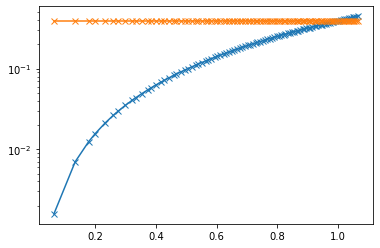

In [27]:
npsi = 3
# for Npsi in [2,4,8,16,32] : 
#     Neta = 10*Npsi
#     config = create_default_config()
#     config["fsa"] = "toroidal-average" # important because cta is not good for toroidal gaussian

#     config["n"] = npsi
#     config["Npsi"] = Npsi
#     config["Neta"] = Neta
#     with open( "config.json", 'w') as f:
#         json.dump( config, f,
#         sort_keys=True, ensure_ascii=True, indent=4)
#     diagfile = diagnoser.recreate( simulationfile)

#     ncin = Dataset( diagfile, 'r', format="NETCDF4")
ncin = Dataset( diagfile, 'r', format="NETCDF4")
arclength = ncin["psi_arc"][:]
area = ncin["psi_vol2d"][:]
psi_psi = ncin["psi_psi"][:]
pir = np.pi*(1-psi_psi)
dvdpsi = ncin["dv2ddpsi"][:]
xc = ncin["xc"][:,:]
yc = ncin["yc"][:,:]
r2 = np.sqrt((xc-3)**2 + yc**2)
print( r2[64,-1]-np.sqrt(1-psi_psi[-1]))
# plt.plot( psi_psi, area, marker='x')
plt.plot( np.sqrt(1-psi_psi), np.abs(pir-area), marker = 'x')
plt.plot( np.sqrt( 1- psi_psi[:]), np.abs(dvdpsi[:]+np.pi), marker = 'x' )
print( dvdpsi[-1]+np.pi, dvdpsi[-2]+np.pi,dvdpsi[-3]+np.pi)
print( pir[-1]-area[-1])
plt.yscale('log')
# plt.xlim(0.,1.0)
# plt.ylim(0,2*np.pi)
plt.show()